# House Price Prediction

Let's import the necessary libraries

In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

Reading the dataset

In [77]:
df = pd.read_csv("Bengaluru_House_Data.csv")

Looking at the first five rows

In [78]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Finding number of rows and columns in our dataset

In [79]:
df.shape

(13320, 9)

We will find the number of houses of each area_type

In [80]:
df.groupby("area_type")["area_type"].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In order to make our dataset simpler we will drop some unimportant columns

In [81]:
df = df.drop(['area_type', 'society', 'balcony', 'availability'], axis = 'columns')
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


Let's find the number of null values in our dataset

In [82]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Since the number of 'na' values are too small in comparison to the whole dataset therefore we can drop the 'na' values

In [83]:
df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Since the column 'size' have different notations therefore wee will try to explore that column

In [84]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

We will replace 'size' column with another column in which the 'bhk' is properly defined.
We can do this by using a function. 

In [85]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [86]:
df['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

Here we can see that it is not quite possible to have 43 bedroom house in only 2400 sqft of area

In [87]:
df[df.bhk > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


Here we can see that there is a range somewhere instead of a definite number.
We can handle this by taking the mean of the range values

In [88]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

This function will give all the rows which are not having a definite number in 'total_sqft' column.

In [89]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [90]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Now we will make a function that will take the average of those ranges and replace them with the range and wherever their is anything else we just delete that record  

In [91]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens)==2:
        return(float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

Let's try the function

In [92]:
convert_sqft_to_num('2166')

2166.0

In [93]:
convert_sqft_to_num('2100-2200')

2150.0

In [94]:
convert_sqft_to_num('4125Perch')

Let's apply this to our dataset

In [95]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

In [96]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


To access any row

In [97]:
df.loc[30]

location      Yelahanka
size              4 BHK
total_sqft         2475
bath                  4
price               186
bhk                   4
Name: 30, dtype: object

Let's do some feature engineering here. We will try to calculate the price per square feet.

In [98]:
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


We will now explore location column

In [99]:
len(df.location.unique())

1304

This function will remove any leading spaces or spaces at the end. 

In [100]:
df.location = df.location.apply(lambda x: x.strip())
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Now we will count the total number of individual locations.

In [101]:
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield                                      535
Sarjapur  Road                                  392
Electronic City                                 304
Kanakpura Road                                  266
Thanisandra                                     236
Yelahanka                                       210
Uttarahalli                                     186
Hebbal                                          176
Marathahalli                                    175
Raja Rajeshwari Nagar                           171
Bannerghatta Road                               152
Hennur Road                                     150
7th Phase JP Nagar                              149
Haralur Road                                    141
Electronic City Phase II                        131
Rajaji Nagar                                    106
Chandapura                                       98
Bellandur                                        96
Hoodi                                            88
KR 

Let's see how many locations are less than 10 in number.

In [102]:
len(location_stats[location_stats <= 10])

1052

We will try to accomodate all the locations which are less than 10 to be place in 'others' column.

In [103]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10.head(5)

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
Name: location, dtype: int64

In [104]:
len(df.location.unique())

1293

In [105]:
df.location=df.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df.location.unique())

242

Now let's explore the outliers. First we will find the records where the total_sqft are unusual.

In [106]:
df[df.total_sqft / df.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [107]:
df.shape

(13246, 7)

We will remove these rows from our database.

In [108]:
df = df[~(df.total_sqft / df.bhk < 300)]

In [109]:
df.shape

(12502, 7)

In [111]:
df.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

Now we will remove the extreme cases from each locations by filtering out the records which are beyound 1 standard deviation.

In [116]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
        df_out = pd.concat([df_out,reduced_df], ignore_index = True)
    return df_out

In [117]:
df = remove_pps_outliers(df)

In [118]:
df.shape

(10241, 7)

Now we will try to remove those recods where the price of 2 bhk are higher than those of 3 bhk.
But first we will try to figure out how many of such records exist.

In [122]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color = 'blue', label = '2 BHK', s=40)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker = '+', color = 'green', label = '3 BHK', s=40)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

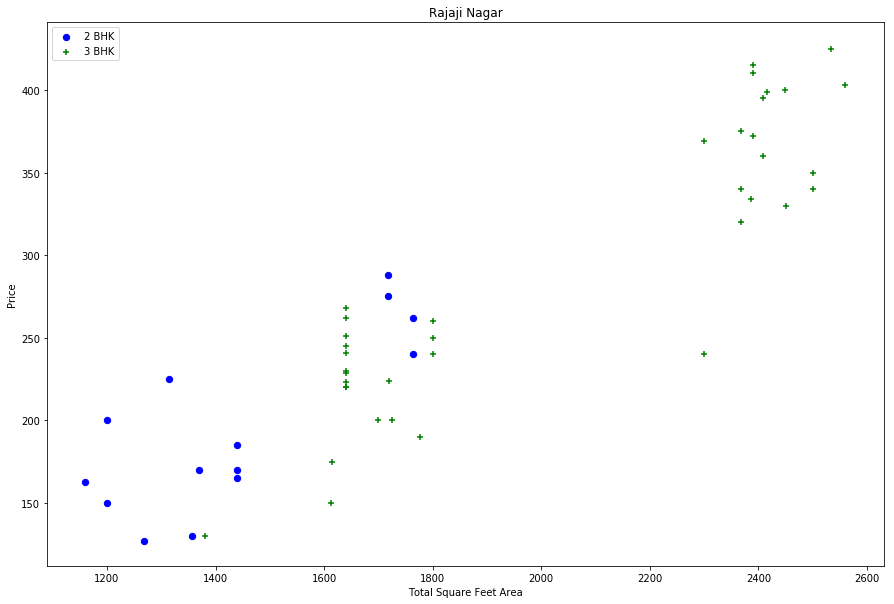

In [123]:
plot_scatter_chart(df, "Rajaji Nagar")

In [128]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')
    

In [129]:
df =remove_bhk_outliers(df)
df.shape

(7329, 7)

Text(0, 0.5, 'Count')

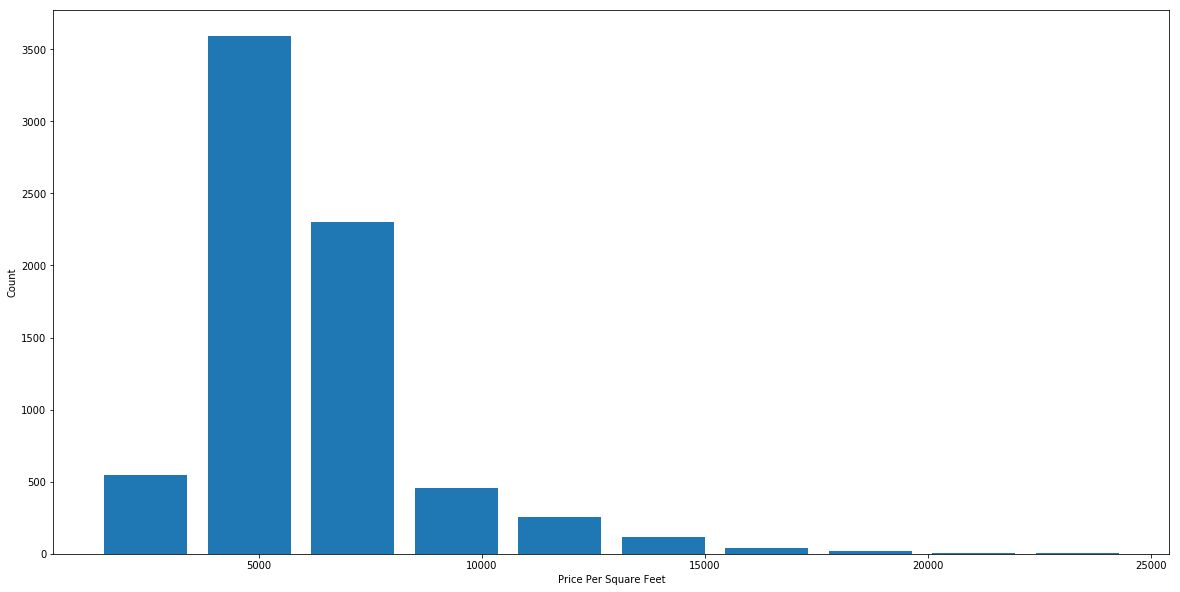

In [132]:
import matplotlib
matplotlib.rcParams[("figure.figsize")] = (20,10)
plt.hist(df.price_per_sqft, rwidth = 0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Now let's explore the bath column.

In [133]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [134]:
df[df.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

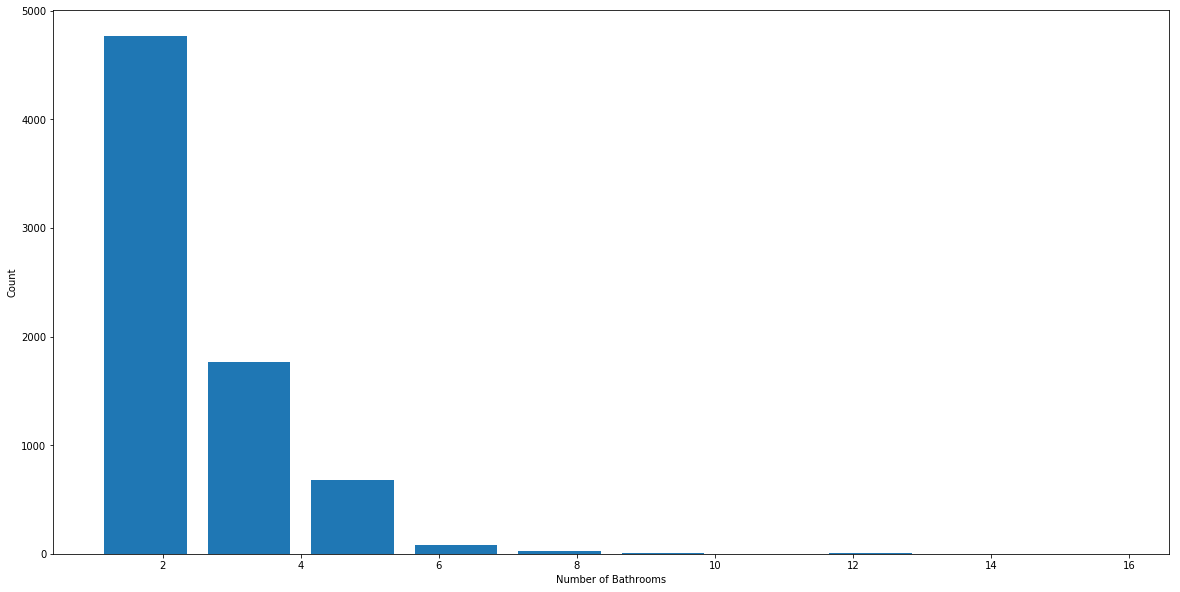

In [135]:
plt.hist(df.bath, rwidth = 0.8)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

Now we can remove the records where the number of bathrooms are 2 greater than the number of rooms.

In [136]:
df[df.bath > df.bhk + 2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [140]:
df = df[df.bath < df.bhk + 2]
df.shape

(7251, 7)

Now we can remove the unwanted attributes from our dataset before giving it to model for training.

In [141]:
df = df.drop(['size', 'price_per_sqft'], axis = 'columns')
df.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


Now we have to convert location into categorical values. For that we will use dummies method.

In [145]:
dummies = pd.get_dummies(df.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
df = pd.concat([df, dummies.drop('other', axis = 'columns')], axis = 'columns')
df.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can drop our location column which has string values.

In [151]:
df = df.drop('location', axis = 'columns')
df.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
df.shape

(7251, 245)

In [153]:
x = df.drop('price', axis = 'columns')
y = df.price

In [154]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10) 

First let's try Linear Regression

In [155]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.845227769787428

Let's try this again but this time using k fold cross validation method.

In [156]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

We can use grid search cv to check our model accuracy with different models.